In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import torchvision
import os
from torchvision.transforms import v2
import glob
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from collections import Counter 

## Data Processing

In [24]:
class AnnotationProcessor:
    def __init__(self, base_path, output_path='/kaggle/working/', filename='dataset.csv'):
        self.base_path = base_path
        self.output_path = output_path
        self.filename = filename
        self.data = None
        self.run()

    def get_group_annotation(self, file, folder_name):
        """Extract the first two elements from each row of the annotation file."""
        with open(file, 'r') as f:
            data = [line.split()[:2] for line in f]

        df = pd.DataFrame(data, columns=['FrameID', 'Label'])
        df['video_names'] = folder_name
## ['l-spike', 'l_set', 'r_set', 'r-pass', 'r_spike', 'l-pass',
       #'r_winpoint', 'l_winpoint']
        label_mapping = {'l-spike': 0, 'l_set': 1, 'r_set': 2, 'r-pass': 3, 'r_spike': 4, 'l-pass': 5, 'r_winpoint': 6, 'l_winpoint': 7}
        df['Mapped_Label'] = df['Label'].map(label_mapping).astype('int64')
        # Ensure the output directory exists
        os.makedirs(self.output_path, exist_ok=True)
        # Save the file directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, f'{folder_name}.csv'), index=False)

    def process_annotations(self):
        """Process annotations from all folders in the base path."""
        for folder_name in os.listdir(self.base_path):
            folder_path = os.path.join(self.base_path, folder_name)
            if os.path.isdir(folder_path):
                annotated_file_path = os.path.join(folder_path, 'annotations.txt')
                self.get_group_annotation(annotated_file_path, folder_name)

    def combine_csv_files(self):
        """Combine all CSV files into a single DataFrame."""
        csv_files = glob.glob(os.path.join(self.output_path, '*.csv'))
        data = [pd.read_csv(csv_file) for csv_file in csv_files]
        for d in data:
            d.dropna(inplace=True)
            # print(d.isna().sum())
        return pd.concat(data, ignore_index=True)

    def generate_img_paths(self, df):
        """Generate image paths based on the DataFrame."""
        df['img_path'] = df.apply(
            lambda x: os.path.join(
                self.base_path,
                str(x['video_names']),  # Ensure `video_names` is a string
                str(x['FrameID'])[:-4],  # Ensure `FrameID` is a string and remove the last 4 characters
                str(x['FrameID'])  # Ensure `FrameID` is a string
            ), axis=1
        )
        return df

    def save_combined_data(self, df):
        """Save the combined data to a CSV file."""
        # Ensure the output directory exists before saving
        os.makedirs(self.output_path, exist_ok=True)
        # Save the combined data directly in the root of the output path
        df.to_csv(os.path.join(self.output_path, self.filename), index=False)

    def cleanup(self):
        """Delete all intermediate CSV files except the final output file."""
        for csv_file in glob.glob(os.path.join(self.output_path, '*.csv')):
            if not csv_file.endswith(self.filename):
                os.remove(csv_file)

    def run(self):
        """Run the whole annotation processing pipeline."""
        self.process_annotations()
        combined_data = self.combine_csv_files()
        data_with_paths = self.generate_img_paths(combined_data)
        self.save_combined_data(data_with_paths)
        self.cleanup()  # Clean up intermediate files
        self.data = pd.read_csv(os.path.join(self.output_path, self.filename))


Make sure you want to run this before running it

In [25]:
!rm -rf '/kaggle/working/'

rm: cannot remove '/kaggle/working/': Device or resource busy


In [26]:
base_path = '/kaggle/input/volleyball/volleyball_/videos/'
df = AnnotationProcessor(base_path, 'dataset.csv').data

## Model

In [27]:
class ResnetEvolution(nn.Module):
    def __init__(self, hidden_layers=[128, 64, 32]):
        super(ResnetEvolution, self).__init__()
        self.hidden_layers = hidden_layers
        self.model = self.__init_backbone(torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2))

    def __init_backbone(self, backbone):
        num_features = backbone.fc.in_features

        layers = []
        input_size = num_features  # Start with backbone output size
        for hidden_size in self.hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())  # Activation function
            input_size = hidden_size  # Update input for next layer

        layers.append(nn.Linear(input_size, 8))  # Final output layer

        backbone.fc = nn.Sequential(*layers)  # Output layer for binary classification

        return backbone

    def get_fc(self):
        return self.model.fc

    def forward(self, images):
        return self.model(images)

## Trainer

In [28]:
class b1_ModelTrainer:
    def __init__(self, model, optimizer, criterion, epochs, dataloaders, device, save_folder, is_continue=False, checkpoint=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloaders = dataloaders
        self.DEVICE = device
        self.save_folder = save_folder
        self.is_continue = is_continue
        self.checkpoint = checkpoint

    #verbose 1 : checkpoint,
    #verbose 3:  labels, preds
    #verbose 4: logits
    def train_model(self, verbose=0):
        model, optimizer, criterion, epochs, dataloaders = self.model, self.optimizer, self.criterion, self.epochs, self.dataloaders

        epoch = 0
        if self.is_continue:

            if verbose>0:
                print(f"Continuing from checkpoint {self.checkpoint}")

            epoch, model, optimizer = self.__load_checkpoint(model, optimizer, self.checkpoint, verbose)

        for training_epoch in range(epoch, epochs):

            # print(f"\nTraining epoch {training_epoch}: training {'full model' if self.__check_transfer_learning(training_epoch/epochs) else 'only fc model'}")

            ## change model mode depending on the phase
            for phase in ['train', 'val']:
                dataloader = dataloaders[phase]
                epoch_loss = 0  # Track total loss for the epoch
                if phase == 'train':
                    model.train()
                    for inputs, labels in tqdm(dataloader, desc=phase):

                        inputs = inputs.to(self.DEVICE)
                        labels = labels.to(self.DEVICE)

                        if verbose > 3:
                            print(f"labels: {labels}")

                        # zero grads of he optim
                        optimizer.zero_grad()

                        # freeze the non-learnable weights
                        # self.__handle_transfer_learning(phase, training_epoch / epochs)

                        # forward pass
                        logit = model(inputs)

                        if verbose > 3:
                            print(f"logit: {logit}")

                        loss = criterion(logit, labels)
                        loss.backward()
                        # update weights
                        optimizer.step()
                        epoch_loss += loss.item()  # Accumulate loss
                    print(
                        f"Epoch {training_epoch + 1}/{epochs}, {phase} Loss: {epoch_loss / len(dataloader)}")  # Print loss
                else:
                    # skip evaluation if no suitable dataloader
                    if dataloaders[phase] is None:
                        continue
                    model.eval()
                    loss, acc = self.__eval_model(dataloader, verbose)
                    print(f"Epoch {training_epoch + 1}/{epochs}, ({phase}) Loss: {loss} | Accuracy: {acc}")  # Print loss


            self.__save_checkpoint(training_epoch, model.state_dict(), optimizer.state_dict(), verbose)

        self.__save_model(verbose)

    def __handle_transfer_learning(self, phase, ratio_epochs, tl_coeff=0, verbose=0):
        if phase == "train":
            if self.__check_transfer_learning(ratio_epochs, tl_coeff):
                # Unfreeze all layers for fine-tuning
                for param in self.model.parameters():
                    param.requires_grad = True
            else:
                # Freeze the CNN part
                for param in self.model.parameters():
                    param.requires_grad = False
                # Unfreeze the classification layer
                for param in self.model.get_fc().parameters():
                    param.requires_grad = True
        elif phase == "val":
            for param in self.model.parameters():
                param.requires_grad = False

    def __check_transfer_learning(self, ratio_epochs, tl_coeff=0):
        return ratio_epochs >= tl_coeff

    def __eval_model(self, dataloader, verbose=0):
        model = self.model
        criterion = self.criterion
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs = inputs.to(self.DEVICE)
                labels = labels.to(self.DEVICE)

                if verbose > 2:
                    print(f"labels: {labels}")

                # Forward pass
                logits = model(inputs)

                if verbose > 3:
                    print(f"logit: {logits}")

                probs = F.softmax(logits, dim=1)  # Apply softmax to get probabilities

                if verbose > 3:
                    print(f"probs: {probs}")

                loss = criterion(logits, labels)
                val_loss += loss.item()  # Accumulate loss

                # Compute accuracy
                predicted = torch.argmax(probs, dim=1)  # Get the class with the highest probability

                if verbose > 2:
                    print(f"predicted: {predicted}")
                    print(f"true/false: {(predicted == labels)}")

                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        # Calculate average loss and accuracy
        avg_loss = val_loss / len(dataloader)
        accuracy = correct_preds / total_preds
        return avg_loss, accuracy

    def __save_model(self, verbose=0):
        torch.save(self.model.state_dict(), self.save_folder + "/b1_model.pth")
        if verbose > 0:
            print(f"Saved model to {self.save_folder}/b1_model.pth")

    def __save_checkpoint(self, epoch, model_state_dict, optimizer_state_dict, verbose=0):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_state_dict,
            'optimizer_state_dict': optimizer_state_dict,
        }
        torch.save(checkpoint, self.save_folder + f'/checkpoint-epoch{epoch}.pth')
        if verbose > 0:
            print(f'Saved checkpoint to {self.save_folder}/checkpoint-epoch{epoch}.pth')

    def __load_checkpoint(self, model, optimizer, checkpoint_path, verbose=0):
        checkpoint = torch.load(checkpoint_path)

        if verbose > 0:
            print(f"Loading checkpoint from {checkpoint_path}")

        epoch = checkpoint['epoch']
        model_state_dict = checkpoint['model_state_dict']
        optimizer_state_dict = checkpoint['optimizer_state_dict']
        model = model.load_state_dict(model_state_dict)
        optimizer = optimizer.load_state_dict(optimizer_state_dict)
        return epoch, model, optimizer

## Dataset

In [29]:
class B1Dataset(Dataset):

    VIDEO_SPLITS = {
        'train': {1, 3, 6, 7, 10, 13, 15, 16, 18, 22, 23, 31, 32, 36, 38, 39, 40, 41, 42, 48, 50, 52, 53, 54},
        'val': {0, 2, 8, 12, 17, 19, 24, 26, 27, 28, 30, 33, 46, 49, 51},
        'test': {4, 5, 9, 11, 14, 20, 21, 25, 29, 34, 35, 37, 43, 44, 45, 47}
    }

    def __init__(self, csv_file, split='train', transform=None):
        self.data = pd.read_csv(csv_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transform

        if split in self.VIDEO_SPLITS:
            self.data = self.data[self.data['video_names'].astype(int).isin(self.VIDEO_SPLITS[split])]
        else:
            raise NameError(f'There is no such split: {split}, only {self.VIDEO_SPLITS}')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['img_path']
        label = self.data.iloc[idx]['Mapped_Label']

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

## Code

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:
train_transform = transforms.Compose([
    transforms.Resize(256),            # Resize shorter side to 256     
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomRotation(degrees=5),                   # Randomly rotate images within ±5 degrees
    transforms.ToTensor(),                                   # Convert PIL images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],        # Normalize using ImageNet mean and std values
                         std=[0.229, 0.224, 0.225]),         # (mean and std are the same used during ResNet pre-training)
])

train_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='train', transform=train_transform)

label_counts = Counter([label.item() for _, label in train_dataset])  
total_samples = len(train_dataset)

class_weights = [total_samples / label_counts[i] if i in label_counts else 0 for i in range(8)]

weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

val_dataset = B1Dataset(csv_file='/kaggle/working/dataset.csv/dataset.csv', split='val')

In [35]:
print(f'class weights: {weights}')

class weights: tensor([ 7.4464,  7.0789,  7.6042,  6.0963,  8.2452,  5.6931, 17.4959, 13.3665],
       device='cuda:0')


In [36]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
!mkdir '/kaggle/working/checkpoints/'

In [40]:
model = ResnetEvolution(hidden_layers=[])
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

save_folder = '/kaggle/working/'
trainer = b1_ModelTrainer(model, optimizer, criterion, epochs=20, dataloaders=dataloaders, device=device, save_folder=save_folder)

In [41]:
trainer.train_model()

train: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]


Epoch 1/20, train Loss: 2.06609250868068


Evaluating: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Epoch 1/20, (val) Loss: 2.0174531312215898 | Accuracy: 0.17747949291573453


train: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]


Epoch 2/20, train Loss: 1.8235418814070083


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Epoch 2/20, (val) Loss: 1.7380898538089933 | Accuracy: 0.3303504847129008


train: 100%|██████████| 68/68 [00:57<00:00,  1.17it/s]


Epoch 3/20, train Loss: 1.4306631526526283


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


Epoch 3/20, (val) Loss: 1.2906811237335205 | Accuracy: 0.48695003728560776


train: 100%|██████████| 68/68 [00:57<00:00,  1.18it/s]


Epoch 4/20, train Loss: 1.1940462545436972


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]


Epoch 4/20, (val) Loss: 1.3031215014911832 | Accuracy: 0.49962714392244595


train: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 5/20, train Loss: 1.1183468743282206


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Epoch 5/20, (val) Loss: 1.3219637331508456 | Accuracy: 0.4750186428038777


train: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]


Epoch 6/20, train Loss: 0.9454538611804738


Evaluating: 100%|██████████| 42/42 [00:24<00:00,  1.68it/s]


Epoch 6/20, (val) Loss: 1.0435535865170615 | Accuracy: 0.5928411633109619


train: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


Epoch 7/20, train Loss: 0.8956318900865667


Evaluating: 100%|██████████| 42/42 [00:24<00:00,  1.73it/s]


Epoch 7/20, (val) Loss: 1.0747519305774145 | Accuracy: 0.6181953765846383


train: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]


Epoch 8/20, train Loss: 0.8505511538070791


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Epoch 8/20, (val) Loss: 1.101768324772517 | Accuracy: 0.6204325130499627


train: 100%|██████████| 68/68 [00:57<00:00,  1.19it/s]


Epoch 9/20, train Loss: 0.8023477985578424


Evaluating: 100%|██████████| 42/42 [00:24<00:00,  1.69it/s]


Epoch 9/20, (val) Loss: 1.0034190111217045 | Accuracy: 0.6167039522744221


train: 100%|██████████| 68/68 [00:55<00:00,  1.22it/s]


Epoch 10/20, train Loss: 0.7771508873385542


Evaluating: 100%|██████████| 42/42 [00:24<00:00,  1.71it/s]


Epoch 10/20, (val) Loss: 0.9431471107971101 | Accuracy: 0.6472781506338553


train: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]


Epoch 11/20, train Loss: 0.7541100444162593


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]


Epoch 11/20, (val) Loss: 0.9839258023670742 | Accuracy: 0.6226696495152871


train: 100%|██████████| 68/68 [00:56<00:00,  1.20it/s]


Epoch 12/20, train Loss: 0.7124863968176001


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.66it/s]


Epoch 12/20, (val) Loss: 0.9023616512616476 | Accuracy: 0.6614466815809098


train: 100%|██████████| 68/68 [00:58<00:00,  1.17it/s]


Epoch 13/20, train Loss: 0.6776235200026456


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]


Epoch 13/20, (val) Loss: 0.9744569276060376 | Accuracy: 0.6674123788217748


train: 100%|██████████| 68/68 [00:58<00:00,  1.15it/s]


Epoch 14/20, train Loss: 0.6285860214163276


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Epoch 14/20, (val) Loss: 1.0239236922491164 | Accuracy: 0.6651752423564504


train: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 15/20, train Loss: 0.6340308202540174


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Epoch 15/20, (val) Loss: 1.0890799363454182 | Accuracy: 0.6167039522744221


train: 100%|██████████| 68/68 [01:00<00:00,  1.13it/s]


Epoch 16/20, train Loss: 0.6252646292833721


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Epoch 16/20, (val) Loss: 0.9773204099564325 | Accuracy: 0.6621923937360179


train: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 17/20, train Loss: 0.5810910121482962


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Epoch 17/20, (val) Loss: 1.0244495755150205 | Accuracy: 0.6413124533929903


train: 100%|██████████| 68/68 [00:59<00:00,  1.15it/s]


Epoch 18/20, train Loss: 0.6385016879614662


Evaluating: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


Epoch 18/20, (val) Loss: 0.8390413664636158 | Accuracy: 0.7278150633855331


train: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 19/20, train Loss: 0.5752277615315774


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s]


Epoch 19/20, (val) Loss: 1.1050114645844413 | Accuracy: 0.6211782252050708


train: 100%|██████████| 68/68 [00:58<00:00,  1.16it/s]


Epoch 20/20, train Loss: 0.5571699683718822


Evaluating: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Epoch 20/20, (val) Loss: 1.0259855460552942 | Accuracy: 0.6599552572706935


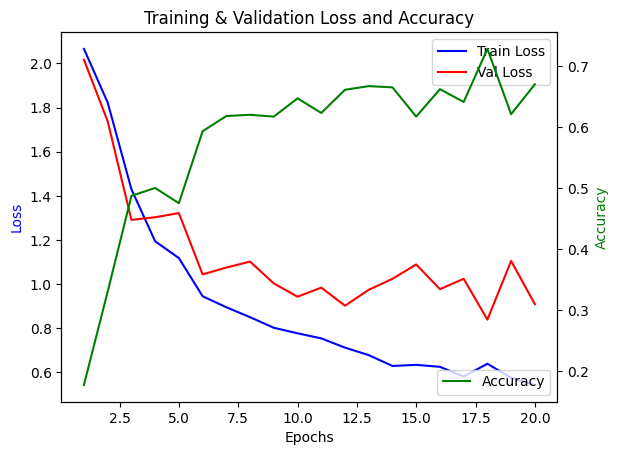

In [42]:
import matplotlib.pyplot as plt

# Data from the logs
epochs = list(range(1, 21))
train_loss = [2.066, 1.823, 1.430, 1.194, 1.118, 0.945, 0.895, 0.850, 0.802, 0.777, 0.754, 0.712, 0.678, 0.629, 0.634, 0.625, 0.581, 0.639, 0.575, 0.543]
val_loss = [2.017, 1.738, 1.291, 1.303, 1.322, 1.044, 1.075, 1.102, 1.003, 0.943, 0.984, 0.902, 0.974, 1.024, 1.089, 0.977, 1.024, 0.839, 1.105, 0.909]
accuracy = [0.177, 0.330, 0.487, 0.500, 0.475, 0.593, 0.618, 0.620, 0.617, 0.647, 0.623, 0.661, 0.667, 0.665, 0.617, 0.662, 0.641, 0.728, 0.621, 0.670]

# Plotting
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(epochs, train_loss, 'b-', label='Train Loss')
ax1.plot(epochs, val_loss, 'r-', label='Val Loss')
ax2.plot(epochs, accuracy, 'g-', label='Accuracy')

# Labels and titles
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Accuracy', color='g')
plt.title('Training & Validation Loss and Accuracy')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

# Show plot
plt.show()